In [1]:
import numpy as np
import tensorflow_datasets as tfds
from PIL import Image
from IPython import display
from transformers import AutoModelForVision2Seq, AutoProcessor
import torch
# get image from tfds
# choose the dataset path in the dropdown on the right and rerun this cell
# to see multiple samples

dataset_name = 'bridge_orig' # @param ['fractal20220817_data', 'kuka', 'bridge', 'taco_play', 'jaco_play', 'berkeley_cable_routing', 'roboturk', 'nyu_door_opening_surprising_effectiveness', 'viola', 'berkeley_autolab_ur5', 'toto', 'language_table', 'columbia_cairlab_pusht_real', 'stanford_kuka_multimodal_dataset_converted_externally_to_rlds', 'nyu_rot_dataset_converted_externally_to_rlds', 'stanford_hydra_dataset_converted_externally_to_rlds', 'austin_buds_dataset_converted_externally_to_rlds', 'nyu_franka_play_dataset_converted_externally_to_rlds', 'maniskill_dataset_converted_externally_to_rlds', 'furniture_bench_dataset_converted_externally_to_rlds', 'cmu_franka_exploration_dataset_converted_externally_to_rlds', 'ucsd_kitchen_dataset_converted_externally_to_rlds', 'ucsd_pick_and_place_dataset_converted_externally_to_rlds', 'austin_sailor_dataset_converted_externally_to_rlds', 'austin_sirius_dataset_converted_externally_to_rlds', 'bc_z', 'usc_cloth_sim_converted_externally_to_rlds', 'utokyo_pr2_opening_fridge_converted_externally_to_rlds', 'utokyo_pr2_tabletop_manipulation_converted_externally_to_rlds', 'utokyo_saytap_converted_externally_to_rlds', 'utokyo_xarm_pick_and_place_converted_externally_to_rlds', 'utokyo_xarm_bimanual_converted_externally_to_rlds', 'robo_net', 'berkeley_mvp_converted_externally_to_rlds', 'berkeley_rpt_converted_externally_to_rlds', 'kaist_nonprehensile_converted_externally_to_rlds', 'stanford_mask_vit_converted_externally_to_rlds', 'tokyo_u_lsmo_converted_externally_to_rlds', 'dlr_sara_pour_converted_externally_to_rlds', 'dlr_sara_grid_clamp_converted_externally_to_rlds', 'dlr_edan_shared_control_converted_externally_to_rlds', 'asu_table_top_converted_externally_to_rlds', 'stanford_robocook_converted_externally_to_rlds', 'eth_agent_affordances', 'imperialcollege_sawyer_wrist_cam', 'iamlab_cmu_pickup_insert_converted_externally_to_rlds', 'uiuc_d3field', 'utaustin_mutex', 'berkeley_fanuc_manipulation', 'cmu_food_manipulation', 'cmu_play_fusion', 'cmu_stretch', 'berkeley_gnm_recon', 'berkeley_gnm_cory_hall', 'berkeley_gnm_sac_son']
#version = '0.1.0'
version = '1.0.0'
local_path = f'/home/lixiang/codebase/openvla/open_x_embodiment/{dataset_name}/{version}'

display_key = 'image_0'
# b = tfds.builder_from_directory(builder_dir=dataset2path(dataset))
b = tfds.builder_from_directory(builder_dir=local_path)
print(b.info.features['steps'])

if display_key not in b.info.features['steps']['observation']:
  raise ValueError(
      f"The key {display_key} was not found in this dataset.\n"
      + "Please choose a different image key to display for this dataset.\n"
      + "Here is the observation spec:\n"
      + str(b.info.features['steps']['observation']))



2024-12-19 11:20:11.089486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 11:20:11.089557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 11:20:11.090467: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 11:20:11.096497: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 11:20:11.942606: W tensorflow/compiler/tf2

Dataset({
    'action': Tensor(shape=(7,), dtype=float32),
    'discount': Scalar(shape=(), dtype=float32),
    'is_first': Scalar(shape=(), dtype=bool),
    'is_last': Scalar(shape=(), dtype=bool),
    'is_terminal': Scalar(shape=(), dtype=bool),
    'language_embedding': Tensor(shape=(512,), dtype=float32),
    'language_instruction': Text(shape=(), dtype=string),
    'observation': FeaturesDict({
        'image_0': Image(shape=(256, 256, 3), dtype=uint8),
        'image_1': Image(shape=(256, 256, 3), dtype=uint8),
        'image_2': Image(shape=(256, 256, 3), dtype=uint8),
        'image_3': Image(shape=(256, 256, 3), dtype=uint8),
        'state': Tensor(shape=(7,), dtype=float32),
    }),
    'reward': Scalar(shape=(), dtype=float32),
})


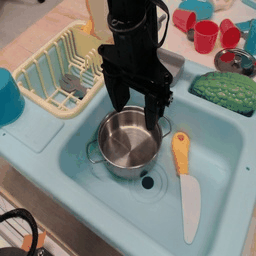

In [2]:
from prismatic import load
def as_gif(images, path='temp.gif'):
  # Render the images as the gif:
  images[0].save(path, save_all=True, append_images=images[1:], duration=100, loop=0)
  gif_bytes = open(path,'rb').read()
  return gif_bytes

ds = b.as_dataset(split='train[100:101]')   # take only first 10 episodes
episode = next(iter(ds))
images = [step['observation'][display_key] for step in episode['steps']]
instructions = [step['language_instruction'] for step in episode['steps']]
images = [Image.fromarray(image.numpy()) for image in images]
display.Image(as_gif(images))

In [5]:
import os
save_image_root = f'/home/lixiang/codebase/embodied-CoT/scripts/generate_trajectory/bridge_image'
os.makedirs(save_image_root, exist_ok=True)
for i, image in enumerate(images):
    save_image_path = os.path.join(save_image_root, f'{i}.jpg')
    image.save(save_image_path)

In [ ]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [ ]:
predictor = SAM2VideoPredictor.from_pretrained("facebook/sam2-hiera-large", device=device)